In [65]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

from nemosis import static_table, dynamic_data_compiler
import plotly.express as px

raw_data_cache = '/Volumes/T7/NEMO_data'

pd.set_option('display.max_columns', None)

# Methodology

Aim: Do a profit maximisation test for a single power station for a single auction.

RD requires bids + dispatch load
MC requires bids + variable fuel costs


NEW:
1. As bids are on a per power station basis, adjust!

OLD:
1. Find MC estimates
2. Group units together by the firms that control them, including the firms's daily declared capacity
3. Create a total marginal cost function which represents the cost curve for all of a firm's generating units, stacked from lowest to highest cost. This creates a stepwise increasing function where: X-axis is cumulative MW across all units, Y-axis is marginal cost ($/MWh), each step represents a different generating unit. Width of step = unit's capacity. Height of step = unit's marginal cost
4. Taking only units that are verified to be "on-line" and operating during that hour
5. Subtracting the day-ahead scheduled quantity to center the function around 0
6. Including only natural gas and coal units that can respond quickly (excluding nuclear, wind, hydro)

#Step 1: MC estimates
Black coal: ~$41-101/MWh
Brown coal: ~$12-13/MWh
Wind/Solar: $0-1/MWh

Methodology:
1. Fuel cost range: 
2. Heat rate
3. Variable O&M (Operations and Maintenance)

Note: 
1. This includes a big assumption that MC is the same across every firm for each fuel type, which is not true!
2. For coal, it would be good to include a shutdown cost - I don't want to arbitrarily limit it like Hortaçsu as emperically coal firms are choosing to shut down

MC estimates:
X-axis: Cumulative quantity of electricity
Y-Axis: Price
MC:
Black coal: ~$41-101/MWh
Brown coal: ~$12-13/MWh
Natural Gas: $60-80/MWh

In [66]:
cost_estimates = {
    "Brown Coal": 12.5,       # Range $12–13 => Midpoint ~12.5
    "Black Coal": 71,         # Range $41–101 => Midpoint ~71
    "Natural Gas": 70,        # Range $60–80 => Midpoint ~70
    "Kerosene": 300,          # Range $200–400 => Midpoint ~300
    "Water": 10     # Range $0–20 => Midpoint ~10
#     "New Large-Scale Hydro": 95  # Range $40–150 => Midpoint ~95
}

In [67]:
# Required to join DUIDs to firm names 
dispatch_units = static_table(table_name='Generators and Scheduled Loads', 
                              raw_data_location=raw_data_cache,
                              update_static_file=False)
dispatch_units

INFO: Retrieving static table Generators and Scheduled Loads


,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
0,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1G
1,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Load,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,ADPBA1L
2,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Non-Scheduled,Hydro,Water,Renewable,Run of River,Y,ADPMH1
3,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y,ADPPV1
4,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Non-Scheduled,Solar,Solar,Renewable,Photovoltaic Flat panel,Y,ADPPV2
...,...,...,...,...,...,...,...,...,...,...,...,...
527,Tailem Bend II Project Company Pty Ltd as trus...,Tailem Bend 2 Hybrid Renewable Power Station,SA1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,TB2B1
528,AGL Macquarie Pty Limited,Broken Hill Battery Energy Storage System,NSW1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,BHB1
529,AGL SA Generation Pty Limited,Torrens Island BESS,SA1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,TIB1
530,Capital Battery Pty Ltd as Trustee for Capital...,Capital Battery,NSW1,Load,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,CAPBES1


In [72]:
# This is the table showing what electricity has been actually dispatched
dispatch_load = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/04/10 00:00:00',
                                   table_name='DISPATCHLOAD',
                                   raw_data_location=raw_data_cache)

dispatch_load

INFO: Compiling data for table DISPATCHLOAD
INFO: Returning DISPATCHLOAD.


,SETTLEMENTDATE,DUID,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
0,2021-03-01 00:05:00,AGLHAL,0,0,0,0.00000,0.00000,720.00,720.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,175.00000,0.00,0.0,0.00,0.0,0
1,2021-03-01 00:05:00,AGLSOM,0,0,0,0.00000,0.00000,480.00,480.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,160.00000,0.00,0.0,0.00,0.0,0
2,2021-03-01 00:05:00,ANGAST1,0,0,0,0.00000,0.00000,840.00,840.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,40.00000,0.00,0.0,0.00,0.0,0
3,2021-03-01 00:05:00,APD01,0,0,0,0.00000,0.00000,0.00,0.00,0.0,0.0,0.00000,0.0001,0.0001,0.0001,0.0,0.0,0.00000,0.00,0.0,0.00,0.0,0
4,2021-03-01 00:05:00,ARWF1,0,0,0,162.50000,161.88836,600.00,1200.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,161.88836,0.00,0.0,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914971,2021-04-10 00:00:00,YENDWF1,0,0,0,11.84000,11.49800,1680.00,1680.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,11.49800,0.00,0.0,0.00,0.0,0
914972,2021-04-10 00:00:00,YWPS1,0,0,0,0.00000,0.00000,180.00,180.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,0.00000,340.25,250.0,340.25,250.0,0
914973,2021-04-10 00:00:00,YWPS2,0,0,0,0.00000,0.00000,180.00,180.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,0.00000,355.25,250.0,355.25,250.0,0
914974,2021-04-10 00:00:00,YWPS3,0,0,1,389.87469,390.00000,180.00,180.00,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0,0.0,390.00000,385.00,250.0,385.00,250.0,0


In [69]:
# We will now merge the dispatch table with info from the Generator table

# Perform an outer join to ensure we keep all DUIDs and settlement dates
merged_df = pd.merge(dispatch_load[['SETTLEMENTDATE', 'DUID']], dispatch_units, on="DUID", how="outer")

# Now merge with the full dispatch_load dataset to bring all the fields together
merged_df = pd.merge(merged_df, dispatch_load, on=["DUID", "SETTLEMENTDATE"], how="outer")

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
898622,2021-03-01 00:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,133.23694,130.0,599.75,599.75,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,210.0,154.28358,110.0,154.28358,110.0,0.0
898623,2021-03-01 00:10:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,129.73663,140.0,599.75,599.75,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,210.0,153.83496,110.0,153.83496,110.0,0.0
898624,2021-03-01 00:15:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,141.50609,130.0,599.75,599.75,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,210.0,156.86850,110.0,156.86850,110.0,0.0
898625,2021-03-01 00:20:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,130.54778,130.0,599.75,599.75,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,210.0,153.04453,110.0,153.04453,110.0,0.0
898626,2021-03-01 00:25:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,131.94595,130.0,599.75,599.75,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,210.0,154.24086,110.0,154.24086,110.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591844,2021-04-09 23:45:00,URANQ14,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.0,659.91,659.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0
3591845,2021-04-09 23:50:00,URANQ14,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.0,659.91,659.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0
3591846,2021-04-09 23:55:00,URANQ14,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.0,659.91,659.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0
3591847,2021-04-10 00:00:00,URANQ14,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.0,659.91,659.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0


In [ ]:
# Filter for 'Origin Energy Electricity Limited' as it's the company with the largest number of power stations
# We join the dispatch_units and the dispatch_load tables on DUID
filtered_df = merged_df[merged_df["Participant"] == "Origin Energy Electricity Limited"]

filtered_df

In [70]:
# We now filter again just for the dispatch loads of Origin Energy electricity plants for the 6:00-6:05pm auction
six_pm_filtered_df = filtered_df[
    filtered_df["SETTLEMENTDATE"].astype(str).str.contains("18:05:00", na=False)
]

with pd.option_context('display.max_rows', None, 
                      'display.max_columns', None,
                      'display.width', None,
                      'display.max_colwidth', None):
    display(six_pm_filtered_df)

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
898838,2021-03-01 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,564.07312,575.00000,180.00,180.00,15.0,15.00000,15.00000,0.00000,0.00000,0.00000,15.00000,0.00000,575.0,575.00000,440.33414,575.00000,440.33414,0.0
899126,2021-03-02 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,457.49655,457.00000,73.52,180.00,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,457.0,457.00000,435.29248,457.00000,435.29248,0.0
899414,2021-03-03 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,432.18747,430.00000,600.00,600.00,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,480.0,415.00000,317.66782,415.00000,317.66782,0.0
899702,2021-03-04 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,549.95282,550.00000,180.00,180.00,15.0,15.00000,0.00000,0.00000,0.00000,0.00000,15.00000,0.00000,550.0,550.00000,435.54883,550.00000,435.54883,0.0
899990,2021-03-05 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,404.48535,410.00000,120.00,120.00,10.0,10.00000,4.32412,0.00000,0.00000,0.00000,10.00000,0.00000,410.0,410.00000,290.89996,410.00000,290.89996,0.0
900278,2021-03-06 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,302.68048,300.00000,600.00,165.06,5.0,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,410.0,307.60583,208.01152,307.60583,208.01152,0.0
900566,2021-03-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,363.77832,373.77832,120.00,120.00,10.0,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,10.00000,415.0,415.00000,287.88779,415.00000,287.88779,0.0
900854,2021-03-08 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,456.82285,455.92596,600.00,600.00,15.0,15.00000,4.60135,15.00000,15.00000,15.00000,15.00000,15.00000,580.0,470.92596,360.00000,470.92596,360.00000,0.0
901142,2021-03-09 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,532.85791,525.00000,180.00,180.00,15.0,15.00000,15.00000,15.00000,15.00000,15.00000,15.00000,0.00000,540.0,540.00000,434.16025,540.00000,434.16025,0.0
901430,2021-03-10 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,536.15253,548.26001,180.00,180.00,10.0,10.00000,10.00000,10.00000,10.00000,10.

In [71]:
# Filter for a single, arbitrary day '2021-04-07'
single_day_six_pm_filtered_df = six_pm_filtered_df[six_pm_filtered_df['SETTLEMENTDATE'].astype(str).str.contains('2021-04-07')]
single_day_six_pm_filtered_df

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
909494,2021-04-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,577.83398,580.00000,180.00,180.00,15.0,15.0,15.0,0.00000,0.00000,0.00000,15.0,0.0,580.0,580.00000,520.00000,580.00000,520.00000,0.0
1116861,2021-04-07 18:05:00,ER01,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,0.0,0.00000,0.00000,299.25,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,500.15002,210.00000,500.15002,210.00000,0.0
1128381,2021-04-07 18:05:00,ER02,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,581.40002,580.00000,300.00,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,580.0,580.00000,350.59998,580.00000,350.59998,0.0
1139901,2021-04-07 18:05:00,ER03,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,639.57495,639.57495,297.00,297.37,0.0,0.0,0.0,0.42505,0.42505,0.42505,7.0,0.0,640.0,639.57495,419.69995,639.57495,419.69995,0.0
1151421,2021-04-07 18:05:00,ER04,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,340.07507,340.00000,298.50,298.88,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,340.0,340.00000,280.00000,340.00000,280.00000,0.0
1750517,2021-04-07 18:05:00,LADBROK1,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,39.59000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0
1762037,2021-04-07 18:05:00,LADBROK2,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,37.33000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0
2208743,2021-04-07 18:05:00,MORTLK11,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,780.00,780.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,271.0,0.00000,125.00000,0.00000,125.00000,0.0
2220263,2021-04-07 18:05:00,MORTLK12,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,262.00000,268.00000,780.00,780.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,268.0,0.00000,125.00000,0.00000,125.00000,0.0
2277865,2021-04-07 18:05:00,MSTUART1,Origin Energy Electricity Limited,Mt Stuart Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Kerosene,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,660.00,660.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,138.0,138.00000,45.00000,138.00000,45.00000,0.0


In [73]:
# Find out more information. There are 26 Origin power stations that bid with the following fuel types
single_day_six_pm_filtered_df.shape
single_day_six_pm_filtered_df['Fuel Source - Descriptor'].unique()

array(['Natural Gas', 'Black Coal', 'Kerosene', 'Water', '-'],
      dtype=object)

In [11]:
# We now need to find the supply bids to work out residual demand and the actual supply bid function
volume_bids = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/04/10 00:00:00',
                                   table_name='BIDPEROFFER_D',
                                   raw_data_location=raw_data_cache)

INFO: Compiling data for table BIDPEROFFER_D
INFO: Downloading data for table BIDPEROFFER_D, year 2021, month 03
INFO: Returning BIDPEROFFER_D.


In [12]:
# Join the dispatch_units and the dispatch_load tables on DUID

# Perform an outer join to ensure we keep all DUIDs and settlement dates
bids_with_duid = pd.merge(volume_bids, dispatch_units, on="DUID", how="outer")

,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation
554750,2021-02-28,DDPS1,ENERGY,2021-02-28 16:57:08,210.0,0.0,0.0,0.0,0.0,110.0,0.0,15.0,0.0,15.0,0.0,0.0,0.0,0.0,523.0,2021-03-01 00:05:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
554751,2021-02-28,DDPS1,LOWER5MIN,2021-02-28 17:03:45,10.0,110.0,210.0,120.0,210.0,25.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,2021-03-01 00:05:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
554752,2021-02-28,DDPS1,LOWER60SEC,2021-02-28 17:03:45,10.0,110.0,210.0,120.0,210.0,25.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,2021-03-01 00:05:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
554753,2021-02-28,DDPS1,LOWER6SEC,2021-02-28 17:03:45,10.0,110.0,210.0,120.0,210.0,25.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2021-03-01 00:05:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
554754,2021-02-28,DDPS1,LOWERREG,2021-02-28 17:03:45,10.0,110.0,210.0,120.0,210.0,20.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,2021-03-01 00:05:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2638756,2021-04-09,URANQ14,ENERGY,2021-04-09 17:31:53,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,2021-04-09 23:45:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
2638757,2021-04-09,URANQ14,ENERGY,2021-04-09 17:31:53,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,2021-04-09 23:50:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
2638758,2021-04-09,URANQ14,ENERGY,2021-04-09 17:31:53,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,2021-04-09 23:55:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
2638759,2021-04-09,URANQ14,ENERGY,2021-04-09 17:31:53,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,2021-04-10 00:00:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y


# Goal: Create the combined supply bid function for Origin

In [74]:
# Filter for 'Origin Energy Electricity Limited'
filtered_bids_df = bids_with_duid[bids_with_duid["Participant"] == "Origin Energy Electricity Limited"]

# Filter for only the 6-6:05pm auctions
six_pm_filtered_bids_df = filtered_bids_df[
    filtered_bids_df["INTERVAL_DATETIME"].astype(str).str.contains("18:00:00", na=False)
]

In [75]:
# Filter for the single day we're looking at '2021-04-07'
target_date = pd.to_datetime('2021-04-07')
single_day_six_pm_filtered_bids_df = six_pm_filtered_bids_df[six_pm_filtered_bids_df['SETTLEMENTDATE'].dt.date == target_date.date()]
single_day_six_pm_filtered_bids_df

,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation
572237,2021-04-07,DDPS1,ENERGY,2021-04-07 16:43:02,580.0,NaN,NaN,NaN,NaN,663.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
572238,2021-04-07,DDPS1,LOWER5MIN,2021-04-07 16:08:21,15.0,520.0,580.0,535.0,580.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
572239,2021-04-07,DDPS1,LOWER60SEC,2021-04-07 16:08:21,15.0,520.0,580.0,535.0,580.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
572240,2021-04-07,DDPS1,LOWER6SEC,2021-04-07 16:08:21,15.0,520.0,580.0,535.0,580.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
572241,2021-04-07,DDPS1,LOWERREG,2021-04-07 16:08:21,15.0,520.0,580.0,535.0,580.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119685,2021-04-07,SHPUMP,ENERGY,2021-04-06 16:17:23,0.0,NaN,NaN,NaN,NaN,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Shoalhaven Power Station (Bendeela And Kangaro...,NSW1,Load,Market,Scheduled,-,-,-,-,Y
2630335,2021-04-07,URANQ11,ENERGY,2021-04-07 16:21:40,150.0,NaN,NaN,NaN,NaN,80.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
2632927,2021-04-07,URANQ12,ENERGY,2021-04-06 11:46:49,153.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
2635519,2021-04-07,URANQ13,ENERGY,2021-04-06 11:46:49,151.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y


In [76]:
energy_only_volume_bids = single_day_six_pm_filtered_bids_df[single_day_six_pm_filtered_bids_df['BIDTYPE'] == 'ENERGY']
energy_only_volume_bids.shape

(26, 31)

In [77]:
unique_DUIDs = single_day_six_pm_filtered_bids_df["DUID"].unique()
unique_DUIDs

array(['DDPS1', 'ER01', 'ER02', 'ER03', 'ER04', 'LADBROK1', 'LADBROK2',
       'MORTLK11', 'MORTLK12', 'MSTUART1', 'MSTUART2', 'MSTUART3',
       'OSB-AG', 'QPS1', 'QPS2', 'QPS3', 'QPS4', 'QPS5', 'ROMA_7',
       'ROMA_8', 'SHGEN', 'SHPUMP', 'URANQ11', 'URANQ12', 'URANQ13',
       'URANQ14'], dtype=object)

In [43]:
# Get the price bids.
price_bids = dynamic_data_compiler(start_time='2021/03/01 00:00:00',
                                   end_time='2021/04/10 00:00:00',
                                   table_name='BIDDAYOFFER_D',
                                   raw_data_location=raw_data_cache)

INFO: Compiling data for table BIDDAYOFFER_D
INFO: Downloading data for table BIDDAYOFFER_D, year 2021, month 03
INFO: Returning BIDDAYOFFER_D.


In [47]:
single_day_price_bids = price_bids[price_bids['SETTLEMENTDATE'] == '2021-04-07']
single_day_price_bids

,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4
0,2021-04-07,ARWF1,ENERGY,2021-03-30 12:19:05,1,-898.30,-157.00,2.00,4.00,8.00,16.00,32.00,64.00,128.0,13025.35,0.0,0.0,0.0,0.0,0.0
1,2021-04-07,ASNENC1,RAISE6SEC,2021-04-06 23:58:13,1,0.03,0.30,0.73,0.99,1.98,5.00,9.90,17.70,100.0,10000.00,0.0,NaN,NaN,NaN,NaN
2,2021-04-07,ASSENC1,RAISE60SEC,2021-04-06 21:35:12,1,0.00,1.00,2.00,4.00,8.00,16.00,32.00,64.00,128.0,256.00,0.0,NaN,NaN,NaN,NaN
3,2021-04-07,ASSENC1,RAISE6SEC,2021-04-06 21:35:12,1,0.00,1.00,2.00,4.00,8.00,16.00,32.00,64.00,128.0,256.00,0.0,NaN,NaN,NaN,NaN
4,2021-04-07,ASTFG1V1,RAISE60SEC,2021-04-01 12:24:25,1,0.00,1.00,2.00,4.00,8.00,16.00,32.00,64.00,128.0,256.00,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2021-04-07,YWPS3,LOWER5MIN,2021-03-23 13:03:24,1,0.08,0.17,0.79,1.19,4.40,9.99,29.99,99.99,249.9,8999.99,0.0,NaN,NaN,NaN,NaN
1160,2021-04-07,YWPS3,RAISE6SEC,2021-03-23 13:03:24,1,0.48,1.75,4.90,20.70,33.33,99.90,630.00,1999.00,6000.0,12299.00,0.0,NaN,NaN,NaN,NaN
1161,2021-04-07,YWPS4,LOWER6SEC,2021-03-23 13:09:10,1,0.03,0.05,0.16,0.30,1.90,25.04,30.04,99.00,4600.0,9899.00,0.0,NaN,NaN,NaN,NaN
1162,2021-04-07,YWPS4,LOWERREG,2021-03-23 13:09:10,1,0.05,1.90,4.78,9.40,14.00,29.00,64.90,240.90,11990.0,14600.00,0.0,NaN,NaN,NaN,NaN


In [79]:
# Note how it matches with the volume bids as there are 95 rows in each
filtered_bids_df = single_day_price_bids[single_day_price_bids["DUID"].isin([
    'DDPS1', 'ER01', 'ER02', 'ER03', 'ER04', 'LADBROK1', 'LADBROK2',
    'MORTLK11', 'MORTLK12', 'MSTUART1', 'MSTUART2', 'MSTUART3',
    'OSB-AG', 'QPS1', 'QPS2', 'QPS3', 'QPS4', 'QPS5', 'ROMA_7',
    'ROMA_8', 'SHGEN', 'SHPUMP', 'URANQ11', 'URANQ12', 'URANQ13',
    'URANQ14'
])]

filtered_bids_df

,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4
28,2021-04-07,DDPS1,LOWER5MIN,2021-04-06 19:01:06,1,0.01,2.50,9.29,20.00,47.00,68.00,100.00,297.00,10399.90,15000.0,0.0,NaN,NaN,NaN,NaN
36,2021-04-07,ER01,LOWERREG,2021-04-01 13:52:55,1,0.00,1.10,4.10,11.00,14.00,45.90,98.20,302.40,12000.00,15000.0,0.0,NaN,NaN,NaN,NaN
37,2021-04-07,ER01,RAISE6SEC,2021-04-01 13:52:55,1,0.00,1.10,5.20,9.30,15.15,29.90,39.50,103.00,12555.00,15000.0,0.0,NaN,NaN,NaN,NaN
38,2021-04-07,ER02,LOWERREG,2021-04-06 18:12:36,1,0.00,1.10,4.10,11.00,14.00,45.90,98.20,302.40,12000.00,15000.0,0.0,NaN,NaN,NaN,NaN
39,2021-04-07,ER03,LOWERREG,2021-04-06 18:12:36,1,0.00,1.10,4.10,11.00,14.00,45.90,98.20,302.40,12000.00,15000.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061,2021-04-07,ER03,RAISE60SEC,2021-04-06 18:12:36,1,0.00,1.10,5.10,10.40,15.10,29.60,39.50,103.00,12290.00,15000.0,0.0,NaN,NaN,NaN,NaN
1062,2021-04-07,ER03,RAISE6SEC,2021-04-06 18:12:36,1,0.00,1.10,5.20,9.30,15.15,29.90,39.50,103.00,12555.00,15000.0,0.0,NaN,NaN,NaN,NaN
1078,2021-04-07,LADBROK2,ENERGY,2021-04-06 11:46:49,1,-968.50,34.53,40.82,48.33,54.62,113.90,277.96,9675.32,12638.74,14527.5,5.0,6.0,1.0,51.0,1.0
1103,2021-04-07,OSB-AG,RAISE6SEC,2021-04-01 13:52:55,1,0.01,0.51,0.79,1.79,4.44,9.99,14.99,19.99,13799.99,15000.0,0.0,NaN,NaN,NaN,NaN


In [80]:
energy_only_price_bids = filtered_bids_df[filtered_bids_df['BIDTYPE'] == 'ENERGY']
energy_only_price_bids.shape

(26, 20)

In [108]:
merged_bids_df = pd.merge(energy_only_price_bids, energy_only_volume_bids, on=["DUID", "SETTLEMENTDATE"])
merged_bids_df

,SETTLEMENTDATE,DUID,BIDTYPE_x,OFFERDATE_x,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4,BIDTYPE_y,OFFERDATE_y,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation
0,2021-04-07,QPS2,ENERGY,2021-04-06 11:46:49,1,-985.40,35.18,49.77,61.61,89.38,115.98,282.91,428.90,12851.80,14781.00,5.0,8.0,2.0,47.0,2.0,ENERGY,2021-04-07 17:01:45,22.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
1,2021-04-07,QPS5,ENERGY,2021-04-06 11:46:49,1,-985.40,35.08,44.84,61.62,68.98,89.28,282.81,9843.16,12851.91,14781.00,74.0,19.0,8.0,24.0,8.0,ENERGY,2021-04-06 11:46:49,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
2,2021-04-07,DDPS1,ENERGY,2021-04-06 14:03:06,1,-960.90,0.00,31.24,35.26,45.46,57.36,64.28,336.32,13736.07,14413.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 16:43:02,580.0,NaN,NaN,NaN,NaN,663.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
3,2021-04-07,ER01,ENERGY,2021-04-06 11:46:38,1,-983.50,12.74,32.11,34.99,38.50,49.55,107.94,273.31,10818.82,14752.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 11:46:38,0.0,NaN,NaN,NaN,NaN,210.0,0.0,250.0,190.0,50.0,0.0,0.0,0.0,0.0,50.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y
4,2021-04-07,ER02,ENERGY,2021-04-06 17:58:14,1,-983.50,12.74,32.11,34.99,38.50,49.55,107.94,273.31,10818.82,14752.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 17:58:14,580.0,NaN,NaN,NaN,NaN,280.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y
5,2021-04-07,LADBROK1,ENERGY,2021-04-06 11:46:49,1,-968.50,34.53,40.82,48.33,54.62,113.90,277.96,9675.32,12638.74,14527.50,5.0,6.0,1.0,51.0,1.0,ENERGY,2021-04-07 17:23:53,41.0,NaN,NaN,NaN,NaN,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
6,2021-04-07,MORTLK11,ENERGY,2021-04-06 11:46:49,1,-984.50,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.50,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-06 11:46:49,268.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
7,2021-04-07,MORTLK12,ENERGY,2021-04-06 11:46:49,1,-984.50,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.50,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-07 15:17:18,264.0,NaN,NaN,NaN,NaN,125.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
8,2021-04-07,MSTUART3,ENERGY,2021-04-06 11:46:49,1,-922.90,45.03,80.20,112.85,275.99,392.64,3220.64,9219.59,12911.09,13843.50,45.0,18.0,5.0,31.

In [109]:
no_zeroes_merged_bids_df = merged_bids_df[merged_bids_df["MAXAVAIL"] != 0]
no_zeroes_merged_bids_df

,SETTLEMENTDATE,DUID,BIDTYPE_x,OFFERDATE_x,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4,BIDTYPE_y,OFFERDATE_y,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation
0,2021-04-07,QPS2,ENERGY,2021-04-06 11:46:49,1,-985.40,35.18,49.77,61.61,89.38,115.98,282.91,428.90,12851.80,14781.00,5.0,8.0,2.0,47.0,2.0,ENERGY,2021-04-07 17:01:45,22.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
2,2021-04-07,DDPS1,ENERGY,2021-04-06 14:03:06,1,-960.90,0.00,31.24,35.26,45.46,57.36,64.28,336.32,13736.07,14413.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 16:43:02,580.0,NaN,NaN,NaN,NaN,663.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y
4,2021-04-07,ER02,ENERGY,2021-04-06 17:58:14,1,-983.50,12.74,32.11,34.99,38.50,49.55,107.94,273.31,10818.82,14752.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 17:58:14,580.0,NaN,NaN,NaN,NaN,280.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y
5,2021-04-07,LADBROK1,ENERGY,2021-04-06 11:46:49,1,-968.50,34.53,40.82,48.33,54.62,113.90,277.96,9675.32,12638.74,14527.50,5.0,6.0,1.0,51.0,1.0,ENERGY,2021-04-07 17:23:53,41.0,NaN,NaN,NaN,NaN,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
6,2021-04-07,MORTLK11,ENERGY,2021-04-06 11:46:49,1,-984.50,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.50,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-06 11:46:49,268.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
7,2021-04-07,MORTLK12,ENERGY,2021-04-06 11:46:49,1,-984.50,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.50,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-07 15:17:18,264.0,NaN,NaN,NaN,NaN,125.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
8,2021-04-07,MSTUART3,ENERGY,2021-04-06 11:46:49,1,-922.90,45.03,80.20,112.85,275.99,392.64,3220.64,9219.59,12911.09,13843.50,45.0,18.0,5.0,31.0,5.0,ENERGY,2021-04-06 11:46:49,115.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mt Stuart Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Kerosene,Combustion,Open Cycle Gas turbines (OCGT),Y
9,2021-04-07,URANQ11,ENERGY,2021-04-06 11:46:49,1,-857.00,30.77,49.55,65.13,85.23,124.69,170.54,246.74,12166.83,12855.00,80.0,6.0,7.0,39.0,7.0,ENERGY,2021-04-07 16:21:40,150.0,NaN,NaN,NaN,NaN,80.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
10,2021-04-07,MSTUART1,ENERGY,2021-04-06 11:46:49,1,-922.90,45.03,80.20,112.85,275.99,392.64,3220.64,9219.59,12911.09,

In [115]:
max_avail = no_zeroes_merged_bids_df['MAXAVAIL'].sum()
max_avail

4046.0

In [116]:
# 1. Identify the band availability columns
bandavail_cols = [f"BANDAVAIL{i}" for i in range(1, 11)]

# 2. Create a new column summing them
no_zeroes_merged_bids_df["TOTAL_BANDAVAIL"] = no_zeroes_merged_bids_df[bandavail_cols].sum(axis=1)

# 3. (Optional) display the updated DataFrame
no_zeroes_merged_bids_df.head()1

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_63431/145297821.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_zeroes_merged_bids_df["TOTAL_BANDAVAIL"] = no_zeroes_merged_bids_df[bandavail_cols].sum(axis=1)


,SETTLEMENTDATE,DUID,BIDTYPE_x,OFFERDATE_x,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4,BIDTYPE_y,OFFERDATE_y,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,TOTAL_BANDAVAIL
0,2021-04-07,QPS2,ENERGY,2021-04-06 11:46:49,1,-985.4,35.18,49.77,61.61,89.38,115.98,282.91,428.90,12851.80,14781.0,5.0,8.0,2.0,47.0,2.0,ENERGY,2021-04-07 17:01:45,22.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,25.0
2,2021-04-07,DDPS1,ENERGY,2021-04-06 14:03:06,1,-960.9,0.00,31.24,35.26,45.46,57.36,64.28,336.32,13736.07,14413.5,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 16:43:02,580.0,NaN,NaN,NaN,NaN,663.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,663.0
4,2021-04-07,ER02,ENERGY,2021-04-06 17:58:14,1,-983.5,12.74,32.11,34.99,38.50,49.55,107.94,273.31,10818.82,14752.5,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 17:58:14,580.0,NaN,NaN,NaN,NaN,280.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,750.0
5,2021-04-07,LADBROK1,ENERGY,2021-04-06 11:46:49,1,-968.5,34.53,40.82,48.33,54.62,113.90,277.96,9675.32,12638.74,14527.5,5.0,6.0,1.0,51.0,1.0,ENERGY,2021-04-07 17:23:53,41.0,NaN,NaN,NaN,NaN,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,50.0
6,2021-04-07,MORTLK11,ENERGY,2021-04-06 11:46:49,1,-984.5,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.5,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-06 11:46:49,268.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,292.0


In [123]:
# def cap_at_maxavail(group):
#     """
#     For each (DUID, SETTLEMENTDATE) group:
#       - sort by ascending price,
#       - enforce that sum of 'BANDAVAIL' never exceeds 'MAXAVAIL',
#       - partially fill the band that crosses MAXAVAIL,
#       - set subsequent bands to zero.
#     """
#     # Sort rows by ascending price so we accumulate from cheapest to most expensive band
#     group = group.sort_values(by="PRICEBAND1")  # or whichever column holds the band price
#     max_avail = group["MAXAVAIL"].iloc[0]      # same for all rows in this group
    
#     running_sum = 0.0
#     capped_values = []
    
#     for _, row in group.iterrows():
#         current_band = row["TOTAL_BANDAVAIL"]  # or sum of BANDAVAIL1..BANDAVAIL10 if needed
#         if running_sum >= max_avail:
#             # Already at or above max availability, so additional volume is 0
#             capped_values.append(0.0)
#             continue
        
#         potential_sum = running_sum + current_band
#         if potential_sum <= max_avail:
#             # We can take this entire band without exceeding max
#             capped_values.append(current_band)
#             running_sum = potential_sum
#         else:
#             # Only partial capacity is needed to reach the limit
#             remainder = max_avail - running_sum
#             capped_values.append(remainder)
#             running_sum += remainder  # (which now equals max_avail)

#     # Create a copy of the group and attach the new capped column
#     new_group = group.copy()
#     new_group["CAPPED_BANDAVAIL"] = capped_values
#     return new_group

# # --------------------------------------------------
# # Example usage (with your DataFrame):
# # --------------------------------------------------
# # Suppose df is your current DataFrame with columns like:
# #   ['SETTLEMENTDATE', 'DUID', 'MAXAVAIL', 'PRICEBAND1', 'TOTAL_BANDAVAIL', ...]

# # 1) Group by (DUID, SETTLEMENTDATE) so each generator/time is processed independently
# capped_df = (
#     no_zeroes_merged_bids_df
#     .groupby(["DUID", "SETTLEMENTDATE"], group_keys=False)
#     .apply(cap_at_maxavail)
# )

# # 2) Check results
# print(capped_df[["DUID", "SETTLEMENTDATE", "TOTAL_BANDAVAIL", "CAPPED_BANDAVAIL", "MAXAVAIL"]])

# # Optionally, you can also create a new cumulative sum for plotting:
# capped_df["CUMSUM_CAPPED"] = capped_df.groupby(["DUID", "SETTLEMENTDATE"])["CAPPED_BANDAVAIL"].cumsum()

# capped_df

        DUID SETTLEMENTDATE  TOTAL_BANDAVAIL  CAPPED_BANDAVAIL  MAXAVAIL
0       QPS2     2021-04-07             25.0              22.0      22.0
2      DDPS1     2021-04-07            663.0             580.0     580.0
4       ER02     2021-04-07            750.0             580.0     580.0
5   LADBROK1     2021-04-07             50.0              41.0      41.0
6   MORTLK11     2021-04-07            292.0             268.0     268.0
7   MORTLK12     2021-04-07            292.0             264.0     264.0
8   MSTUART3     2021-04-07            139.0             115.0     115.0
9    URANQ11     2021-04-07            166.0             150.0     150.0
10  MSTUART1     2021-04-07            152.0             138.0     138.0
11      QPS1     2021-04-07             29.0              27.0      27.0
12      QPS4     2021-04-07             25.0              22.0      22.0
13    ROMA_7     2021-04-07             42.0              33.0      33.0
14     SHGEN     2021-04-07            240.0       

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_63431/4037025973.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(cap_at_maxavail)


,SETTLEMENTDATE,DUID,BIDTYPE_x,OFFERDATE_x,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4,BIDTYPE_y,OFFERDATE_y,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,TOTAL_BANDAVAIL,CAPPED_BANDAVAIL,CUMSUM_CAPPED
0,2021-04-07,QPS2,ENERGY,2021-04-06 11:46:49,1,-985.40,35.18,49.77,61.61,89.38,115.98,282.91,428.90,12851.80,14781.00,5.0,8.0,2.0,47.0,2.0,ENERGY,2021-04-07 17:01:45,22.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,25.0,22.0,22.0
2,2021-04-07,DDPS1,ENERGY,2021-04-06 14:03:06,1,-960.90,0.00,31.24,35.26,45.46,57.36,64.28,336.32,13736.07,14413.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 16:43:02,580.0,NaN,NaN,NaN,NaN,663.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,663.0,580.0,580.0
4,2021-04-07,ER02,ENERGY,2021-04-06 17:58:14,1,-983.50,12.74,32.11,34.99,38.50,49.55,107.94,273.31,10818.82,14752.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 17:58:14,580.0,NaN,NaN,NaN,NaN,280.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,750.0,580.0,580.0
5,2021-04-07,LADBROK1,ENERGY,2021-04-06 11:46:49,1,-968.50,34.53,40.82,48.33,54.62,113.90,277.96,9675.32,12638.74,14527.50,5.0,6.0,1.0,51.0,1.0,ENERGY,2021-04-07 17:23:53,41.0,NaN,NaN,NaN,NaN,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,50.0,41.0,41.0
6,2021-04-07,MORTLK11,ENERGY,2021-04-06 11:46:49,1,-984.50,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.50,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-06 11:46:49,268.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,292.0,268.0,268.0
7,2021-04-07,MORTLK12,ENERGY,2021-04-06 11:46:49,1,-984.50,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.50,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-07 15:17:18,264.0,NaN,NaN,NaN,NaN,125.0,0.0,0.0,167.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,292.0,264.0,264.0
8,2021-04-07,MSTUART3,ENERGY,2021-04-06 11:46:49,1,-922.90,45.03,80.20,112.85,275.99,392.64,3220.64,9219.59,12911.09,13843.50,45.0,18.0,5.0,31.0,5.0,ENERGY,2021-04-06 11:46:49,115.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mt Stuart Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Kerosene,Combustion,Open Cycle Gas turbines (OCGT),Y,139.0,115.0,115.0
9,2021-04-07,URANQ11,ENERGY,2021-04-06 11:46:49,1,-857.00,30.77,49.55,65.13,85.23,124.69,170.54,246.74,12166.83,12855.00,80.0,6.0,7.0,39.0,7.0,ENERGY,2021-04-07 16:21:40,150.0,NaN,NaN,NaN,NaN,80.0,0.0,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural

In [125]:
import pandas as pd
import numpy as np

def cap_bands_in_wide_mode(group):
    """
    For each row in the group (same DUID & SETTLEMENTDATE):
      1) Sort the 10 band pairs by ascending price.
      2) Accumulate volumes, stopping at MAXAVAIL.
      3) Partially fill the band where we hit the limit.
      4) Set subsequent bands to zero.
      5) Write the modified band volumes back in the original wide order.
    """
    # We'll modify each row separately
    new_rows = []
    
    for _, row in group.iterrows():
        
        # Extract max_avail for this row
        max_avail = row["MAXAVAIL"]
        
        # Gather the 10 band pairs: (price, volume, band_index)
        # E.g., (PRICEBAND1, BANDAVAIL1, index=1), etc.
        band_info = []
        for i in range(1, 11):
            price_col = f"PRICEBAND{i}"
            vol_col   = f"BANDAVAIL{i}"
            
            price_val = row[price_col]
            vol_val   = row[vol_col]
            
            band_info.append((price_val, vol_val, i))
        
        # Sort by ascending price
        band_info.sort(key=lambda x: x[0] if not pd.isna(x[0]) else np.inf)
        
        # Accumulate volumes, capping at max_avail
        running_sum = 0.0
        capped_bands = []
        
        for (price, volume, idx) in band_info:
            if pd.isna(volume): 
                # If volume is NaN, treat it as 0
                volume = 0.0
            
            if running_sum >= max_avail:
                # Already at or beyond limit
                capped_bands.append((price, 0.0, idx))
            else:
                potential = running_sum + volume
                if potential <= max_avail:
                    # Can use full band
                    capped_bands.append((price, volume, idx))
                    running_sum += volume
                else:
                    # Partially use this band
                    remainder = max_avail - running_sum
                    capped_bands.append((price, remainder, idx))
                    running_sum += remainder
        
        # Now re-sort by the original band index so we can put them back into the row
        capped_bands.sort(key=lambda x: x[2])
        
        # Write them back into the row's band columns
        row_capped = row.copy()  # copy original
        for (price, cap_vol, idx) in capped_bands:
            vol_col = f"BANDAVAIL{idx}"
            row_capped[vol_col] = cap_vol
        
        new_rows.append(row_capped)
    
    # Return the modified rows as a DataFrame
    return pd.DataFrame(new_rows)

# -------------------------------------------------------------------
# USAGE EXAMPLE:
# Let's say you have no_zeroes_merged_bids_df with columns:
#   DUID, SETTLEMENTDATE, MAXAVAIL,
#   PRICEBAND1..PRICEBAND10,
#   BANDAVAIL1..BANDAVAIL10
# -------------------------------------------------------------------

capped_wide_df = (
    no_zeroes_merged_bids_df
    .groupby(["DUID", "SETTLEMENTDATE"], group_keys=False)
    .apply(cap_bands_in_wide_mode)
)

# Check that each row's sum is <= MAXAVAIL now
capped_wide_df["SUM_OF_BANDAVAIL"] = capped_wide_df[[f"BANDAVAIL{i}" for i in range(1, 11)]].sum(axis=1)
print(capped_wide_df[[
    "DUID", "SETTLEMENTDATE", "MAXAVAIL", "SUM_OF_BANDAVAIL"
]])
capped_wide_df

        DUID SETTLEMENTDATE  MAXAVAIL  SUM_OF_BANDAVAIL
0       QPS2     2021-04-07      22.0              22.0
2      DDPS1     2021-04-07     580.0             580.0
4       ER02     2021-04-07     580.0             580.0
5   LADBROK1     2021-04-07      41.0              41.0
6   MORTLK11     2021-04-07     268.0             268.0
7   MORTLK12     2021-04-07     264.0             264.0
8   MSTUART3     2021-04-07     115.0             115.0
9    URANQ11     2021-04-07     150.0             150.0
10  MSTUART1     2021-04-07     138.0             138.0
11      QPS1     2021-04-07      27.0              27.0
12      QPS4     2021-04-07      22.0              22.0
13    ROMA_7     2021-04-07      33.0              33.0
14     SHGEN     2021-04-07     160.0             160.0
15      ER03     2021-04-07     640.0             640.0
16  MSTUART2     2021-04-07     138.0             138.0
19    ROMA_8     2021-04-07      32.0              32.0
21   URANQ12     2021-04-07     153.0           

/var/folders/xw/3fpv2dn948lcf41k_wd6vbxh0000gn/T/ipykernel_63431/1730883804.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(cap_bands_in_wide_mode)


,SETTLEMENTDATE,DUID,BIDTYPE_x,OFFERDATE_x,VERSIONNO,PRICEBAND1,PRICEBAND2,PRICEBAND3,PRICEBAND4,PRICEBAND5,PRICEBAND6,PRICEBAND7,PRICEBAND8,PRICEBAND9,PRICEBAND10,MINIMUMLOAD,T1,T2,T3,T4,BIDTYPE_y,OFFERDATE_y,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,TOTAL_BANDAVAIL,SUM_OF_BANDAVAIL
0,2021-04-07,QPS2,ENERGY,2021-04-06 11:46:49,1,-985.40,35.18,49.77,61.61,89.38,115.98,282.91,428.90,12851.80,14781.00,5.0,8.0,2.0,47.0,2.0,ENERGY,2021-04-07 17:01:45,22.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,25.0,22.0
2,2021-04-07,DDPS1,ENERGY,2021-04-06 14:03:06,1,-960.90,0.00,31.24,35.26,45.46,57.36,64.28,336.32,13736.07,14413.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-07 16:43:02,580.0,NaN,NaN,NaN,NaN,580.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,663.0,580.0
4,2021-04-07,ER02,ENERGY,2021-04-06 17:58:14,1,-983.50,12.74,32.11,34.99,38.50,49.55,107.94,273.31,10818.82,14752.50,0.0,0.0,0.0,0.0,0.0,ENERGY,2021-04-06 17:58:14,580.0,NaN,NaN,NaN,NaN,280.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,750.0,580.0
5,2021-04-07,LADBROK1,ENERGY,2021-04-06 11:46:49,1,-968.50,34.53,40.82,48.33,54.62,113.90,277.96,9675.32,12638.74,14527.50,5.0,6.0,1.0,51.0,1.0,ENERGY,2021-04-07 17:23:53,41.0,NaN,NaN,NaN,NaN,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,50.0,41.0
6,2021-04-07,MORTLK11,ENERGY,2021-04-06 11:46:49,1,-984.50,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.50,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-06 11:46:49,268.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,268.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,292.0,268.0
7,2021-04-07,MORTLK12,ENERGY,2021-04-06 11:46:49,1,-984.50,-31.01,34.95,41.40,56.95,64.39,116.07,9833.19,13340.47,14767.50,120.0,8.0,9.0,33.0,9.0,ENERGY,2021-04-07 15:17:18,264.0,NaN,NaN,NaN,NaN,125.0,0.0,0.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,292.0,264.0
8,2021-04-07,MSTUART3,ENERGY,2021-04-06 11:46:49,1,-922.90,45.03,80.20,112.85,275.99,392.64,3220.64,9219.59,12911.09,13843.50,45.0,18.0,5.0,31.0,5.0,ENERGY,2021-04-06 11:46:49,115.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Mt Stuart Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Kerosene,Combustion,Open Cycle Gas turbines (OCGT),Y,139.0,115.0
9,2021-04-07,URANQ11,ENERGY,2021-04-06 11:46:49,1,-857.00,30.77,49.55,65.13,85.23,124.69,170.54,246.74,12166.83,12855.00,80.0,6.0,7.0,39.0,7.0,ENERGY,2021-04-07 16:21:40,150.0,NaN,NaN,NaN,NaN,80.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-04-07 18:00:00,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,166.0,

In [117]:
# Create a new DataFrame containing just MAXAVAIL and TOTAL_BANDAVAIL
final_df = no_zeroes_merged_bids_df[["MAXAVAIL", "TOTAL_BANDAVAIL"]]

# Display *all* rows by temporarily adjusting pandas settings (optional)
with pd.option_context('display.max_rows', None):
    print(final_df)

    MAXAVAIL  TOTAL_BANDAVAIL
0       22.0             25.0
2      580.0            663.0
4      580.0            750.0
5       41.0             50.0
6      268.0            292.0
7      264.0            292.0
8      115.0            139.0
9      150.0            166.0
10     138.0            152.0
11      27.0             29.0
12      22.0             25.0
13      33.0             42.0
14     160.0            240.0
15     640.0            750.0
16     138.0            152.0
19      32.0             42.0
21     153.0            166.0
22     340.0            750.0
23     151.0            166.0
24     152.0            166.0
25      40.0             50.0


In [126]:
price_columns = [f"PRICEBAND{i}" for i in range(1, 11)]
volume_columns = [f"BANDAVAIL{i}" for i in range(1, 11)]

# Melt price and volume bands into long format
melted_prices = capped_wide_df.melt(id_vars=["DUID", "SETTLEMENTDATE"], 
                                    value_vars=price_columns, 
                                    var_name="PRICE_BAND", value_name="PRICE")

melted_volumes = capped_wide_df.melt(id_vars=["DUID", "SETTLEMENTDATE"], 
                                    value_vars=volume_columns, 
                                    var_name="VOLUME_BAND", value_name="VOLUME")

# Ensure price and volume bands are aligned (i.e., PRICEBAND1 with BANDAVAIL1, etc.)
melted_prices["BAND_NUMBER"] = melted_prices["PRICE_BAND"].str.extract("(\d+)").astype(int)
melted_volumes["BAND_NUMBER"] = melted_volumes["VOLUME_BAND"].str.extract("(\d+)").astype(int)

# Merge long-format prices and volumes
bid_curve_df = pd.merge(melted_prices, melted_volumes, on=["DUID", "SETTLEMENTDATE", "BAND_NUMBER"])
bid_curve_df

,DUID,SETTLEMENTDATE,PRICE_BAND,PRICE,BAND_NUMBER,VOLUME_BAND,VOLUME
0,QPS2,2021-04-07,PRICEBAND1,-985.4,1,BANDAVAIL1,0.0
1,DDPS1,2021-04-07,PRICEBAND1,-960.9,1,BANDAVAIL1,580.0
2,ER02,2021-04-07,PRICEBAND1,-983.5,1,BANDAVAIL1,280.0
3,LADBROK1,2021-04-07,PRICEBAND1,-968.5,1,BANDAVAIL1,41.0
4,MORTLK11,2021-04-07,PRICEBAND1,-984.5,1,BANDAVAIL1,0.0
...,...,...,...,...,...,...,...
205,URANQ12,2021-04-07,PRICEBAND10,12855.0,10,BANDAVAIL10,153.0
206,ER04,2021-04-07,PRICEBAND10,14767.5,10,BANDAVAIL10,0.0
207,URANQ13,2021-04-07,PRICEBAND10,12855.0,10,BANDAVAIL10,151.0
208,URANQ14,2021-04-07,PRICEBAND10,12855.0,10,BANDAVAIL10,152.0


In [127]:
bid_curve_df = bid_curve_df.sort_values(by=["DUID", "SETTLEMENTDATE", "PRICE"])
bid_curve_df["CUMULATIVE_VOLUME"] = bid_curve_df.groupby(["DUID", "SETTLEMENTDATE"])["VOLUME"].cumsum()
with pd.option_context('display.max_rows', None, 
                      'display.max_columns', None,
                      'display.width', None,
                      'display.max_colwidth', None):
    display(bid_curve_df)

,DUID,SETTLEMENTDATE,PRICE_BAND,PRICE,BAND_NUMBER,VOLUME_BAND,VOLUME,CUMULATIVE_VOLUME
1,DDPS1,2021-04-07,PRICEBAND1,-960.90,1,BANDAVAIL1,580.0,580.0
22,DDPS1,2021-04-07,PRICEBAND2,0.00,2,BANDAVAIL2,0.0,580.0
43,DDPS1,2021-04-07,PRICEBAND3,31.24,3,BANDAVAIL3,0.0,580.0
64,DDPS1,2021-04-07,PRICEBAND4,35.26,4,BANDAVAIL4,0.0,580.0
85,DDPS1,2021-04-07,PRICEBAND5,45.46,5,BANDAVAIL5,0.0,580.0
106,DDPS1,2021-04-07,PRICEBAND6,57.36,6,BANDAVAIL6,0.0,580.0
127,DDPS1,2021-04-07,PRICEBAND7,64.28,7,BANDAVAIL7,0.0,580.0
148,DDPS1,2021-04-07,PRICEBAND8,336.32,8,BANDAVAIL8,0.0,580.0
169,DDPS1,2021-04-07,PRICEBAND9,13736.07,9,BANDAVAIL9,0.0,580.0
190,DDPS1,2021-04-07,PRICEBAND10,14413.50,10,BANDAVAIL10,0.0,580.0


In [128]:
# Group by price level and sum the volumes for all DUIDs
aggregated_bids_df = bid_curve_df.groupby(["SETTLEMENTDATE", "PRICE"], as_index=False).agg({"VOLUME": "sum"})

# Sort by price to create a stepwise function
aggregated_bids_df = aggregated_bids_df.sort_values(by=["SETTLEMENTDATE", "PRICE"])

# Compute cumulative volume
aggregated_bids_df["CUMULATIVE_VOLUME"] = aggregated_bids_df.groupby("SETTLEMENTDATE")["VOLUME"].cumsum()

with pd.option_context('display.max_rows', None, 
                      'display.max_columns', None,
                      'display.width', None,
                      'display.max_colwidth', None):
    display(aggregated_bids_df)

,SETTLEMENTDATE,PRICE,VOLUME,CUMULATIVE_VOLUME
0,2021-04-07,-985.40,27.0,27.0
1,2021-04-07,-984.50,615.0,642.0
2,2021-04-07,-983.50,280.0,922.0
3,2021-04-07,-980.90,120.0,1042.0
4,2021-04-07,-968.50,81.0,1123.0
5,2021-04-07,-963.42,32.0,1155.0
6,2021-04-07,-960.90,580.0,1735.0
7,2021-04-07,-922.90,0.0,1735.0
8,2021-04-07,-857.00,80.0,1815.0
9,2021-04-07,-31.01,0.0,1815.0


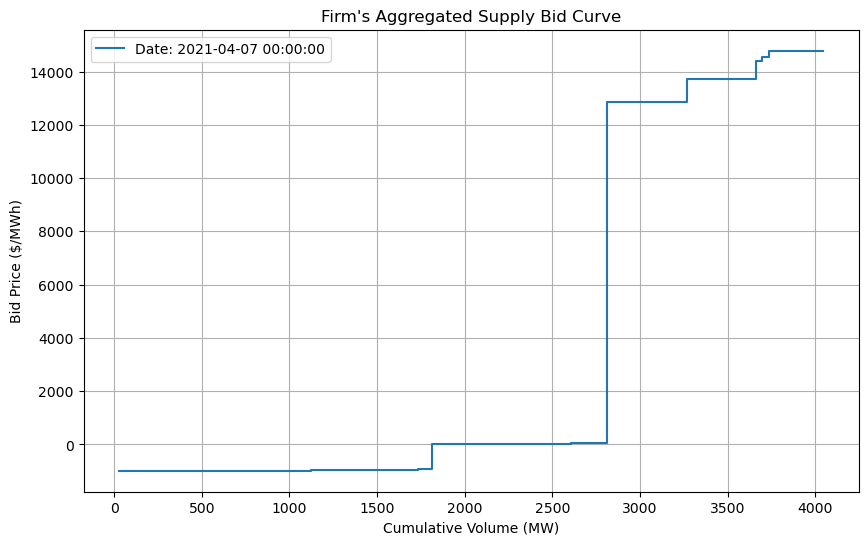

In [130]:
# Non-truncated at the max_avail
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for settlement_date, df in aggregated_bids_df.groupby("SETTLEMENTDATE"):
    plt.step(df["CUMULATIVE_VOLUME"], df["PRICE"], where="post", label=f"Date: {settlement_date}")

plt.xlabel("Cumulative Volume (MW)")
plt.ylabel("Bid Price ($/MWh)")
plt.title("Firm's Aggregated Supply Bid Curve")
plt.legend()
plt.grid()
plt.show()

In [18]:
single_day_six_pm_filtered_df.head()

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
909494,2021-04-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,577.83398,580.00000,180.00,180.00,15.0,15.0,15.0,0.00000,0.00000,0.00000,15.0,0.0,580.0,580.00000,520.00000,580.00000,520.00000,0.0
1116861,2021-04-07 18:05:00,ER01,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,0.0,0.00000,0.00000,299.25,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,500.15002,210.00000,500.15002,210.00000,0.0
1128381,2021-04-07 18:05:00,ER02,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,581.40002,580.00000,300.00,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,580.0,580.00000,350.59998,580.00000,350.59998,0.0
1139901,2021-04-07 18:05:00,ER03,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,639.57495,639.57495,297.00,297.37,0.0,0.0,0.0,0.42505,0.42505,0.42505,7.0,0.0,640.0,639.57495,419.69995,639.57495,419.69995,0.0
1151421,2021-04-07 18:05:00,ER04,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,340.07507,340.00000,298.50,298.88,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,340.0,340.00000,280.00000,340.00000,280.00000,0.0


In [94]:
# In this df of all bids from Origin energy at the 6-6:05pm auction on a specific day
# we want to include the marginal costs based on the fuel time of each power station

single_day_six_pm_filtered_df = single_day_six_pm_filtered_df.copy()

single_day_six_pm_filtered_df["MC per MW/h"] = (
    single_day_six_pm_filtered_df["Fuel Source - Descriptor"].map(cost_estimates)
)

single_day_six_pm_filtered_df

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP,MC per MW/h
909494,2021-04-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,577.83398,580.00000,180.00,180.00,15.0,15.0,15.0,0.00000,0.00000,0.00000,15.0,0.0,580.0,580.00000,520.00000,580.00000,520.00000,0.0,70.0
1116861,2021-04-07 18:05:00,ER01,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,0.0,0.00000,0.00000,299.25,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,500.15002,210.00000,500.15002,210.00000,0.0,71.0
1128381,2021-04-07 18:05:00,ER02,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,581.40002,580.00000,300.00,300.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,580.0,580.00000,350.59998,580.00000,350.59998,0.0,71.0
1139901,2021-04-07 18:05:00,ER03,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,639.57495,639.57495,297.00,297.37,0.0,0.0,0.0,0.42505,0.42505,0.42505,7.0,0.0,640.0,639.57495,419.69995,639.57495,419.69995,0.0,71.0
1151421,2021-04-07 18:05:00,ER04,Origin Energy Electricity Limited,Eraring Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,340.07507,340.00000,298.50,298.88,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,340.0,340.00000,280.00000,340.00000,280.00000,0.0,71.0
1750517,2021-04-07 18:05:00,LADBROK1,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,39.59000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0
1762037,2021-04-07 18:05:00,LADBROK2,Origin Energy Electricity Limited,Ladbroke Grove Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,37.33000,41.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,41.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0
2208743,2021-04-07 18:05:00,MORTLK11,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,780.00,780.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,271.0,0.00000,125.00000,0.00000,125.00000,0.0,70.0
2220263,2021-04-07 18:05:00,MORTLK12,Origin Energy Electricity Limited,Mortlake Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,262.00000,268.00000,780.00,780.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,268.0,0.00000,125.00000,0.00000,125.00000,0.0,70.0
2277865,2021-04-07 18:05:00,MSTUART1,Origin Energy Electricity Limited,Mt Stuart Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Kerosene,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,660.00,660.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,138.0,138.00000,45.00000,138.00000,45.00000,0.0,300.0


In [95]:
# Sorting by MC per MW/h as a firm would dispatch their lowest cost power stations first
single_day_six_pm_filtered_df.sort_values("MC per MW/h", inplace=True)
single_day_six_pm_filtered_df

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP,MC per MW/h
3095813,2021-04-07 18:05:00,SHGEN,Origin Energy Electricity Limited,Shoalhaven Power Station (Bendeela And Kangaro...,NSW1,Generating Unit,Market,Scheduled,Hydro,Water,Renewable,Hydro - Gravity,Y,0.0,4.0,0.0,121.99376,120.00000,600.00,600.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,160.0,0.00000,0.00000,0.00000,0.00000,0.0,10.0
909494,2021-04-07 18:05:00,DDPS1,Origin Energy Electricity Limited,Darling Downs Power Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Combined Cycle Gas Turbine (CCGT),Y,0.0,0.0,1.0,577.83398,580.00000,180.00,180.00,15.0,15.0,15.0,0.00000,0.00000,0.00000,15.0,0.0,580.0,580.00000,520.00000,580.00000,520.00000,0.0,70.0
3568160,2021-04-07 18:05:00,URANQ12,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,659.91,659.91,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,154.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0
3556640,2021-04-07 18:05:00,URANQ11,Origin Energy Electricity Limited,Uranquinty Power Station,NSW1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,1.0,150.50000,151.00000,659.91,659.91,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,151.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0
2727165,2021-04-07 18:05:00,ROMA_8,Origin Energy Electricity Limited,Roma Gas Turbine Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,4.0,0.0,32.89005,32.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,32.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0
2715645,2021-04-07 18:05:00,ROMA_7,Origin Energy Electricity Limited,Roma Gas Turbine Station,QLD1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,480.00,480.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,33.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0
2681080,2021-04-07 18:05:00,QPS5,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,600.00,600.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.00000,74.00000,0.00000,74.00000,0.0,70.0
2669560,2021-04-07 18:05:00,QPS4,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,180.00,180.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,22.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0
2658040,2021-04-07 18:05:00,QPS3,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,180.00,180.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0
2646520,2021-04-07 18:05:00,QPS2,Origin Energy Electricity Limited,Quarantine Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,0.0,0.0,0.0,0.00000,0.00000,180.00,180.00,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.0,22.0,0.00000,0.00000,0.00000,0.00000,0.0,70.0


In [106]:
# 1. Create a subset DataFrame containing only the two columns
subset_df = single_day_six_pm_filtered_df[["AVAILABILITY", "TOTALCLEARED"]]

# 2. Identify rows where TOTALCLEARED > AVAILABILITY
exceeding_rows = subset_df[subset_df["TOTALCLEARED"] > subset_df["AVAILABILITY"]]

# 3. Display the subset and any rows exceeding availability
print("Subset of DataFrame (only AVAILABILITY, TOTALCLEARED):")
print(subset_df)

print("\nRows where TOTALCLEARED > AVAILABILITY:")
print(exceeding_rows)

Subset of DataFrame (only AVAILABILITY, TOTALCLEARED):
         AVAILABILITY  TOTALCLEARED
3095813         160.0     120.00000
909494          580.0     580.00000
3568160         154.0       0.00000
3556640         151.0     151.00000
2727165          32.0      32.00000
2715645          33.0       0.00000
2681080           0.0       0.00000
2669560          22.0       0.00000
2658040           0.0       0.00000
2646520          22.0       0.00000
2635000          28.0      28.00000
3579680         152.0       0.00000
2519792           0.0       0.00000
2220263         268.0     268.00000
2208743         271.0       0.00000
1762037          41.0      41.00000
1750517          41.0      41.00000
3591200         153.0       0.00000
1151421         340.0     340.00000
1139901         640.0     639.57495
1128381         580.0     580.00000
1116861           0.0       0.00000
2289385         138.0       0.00000
2277865         138.0       0.00000
2300905         116.0       0.00000
3107334  

In [96]:
total_avail = single_day_six_pm_filtered_df['AVAILABILITY'].sum()
total_avail

4060.0

In [98]:
# Should be equivalent bids - yes!

total_avail_bids = energy_only_volume_bids['MAXAVAIL'].sum()
total_avail_bids

4046.0

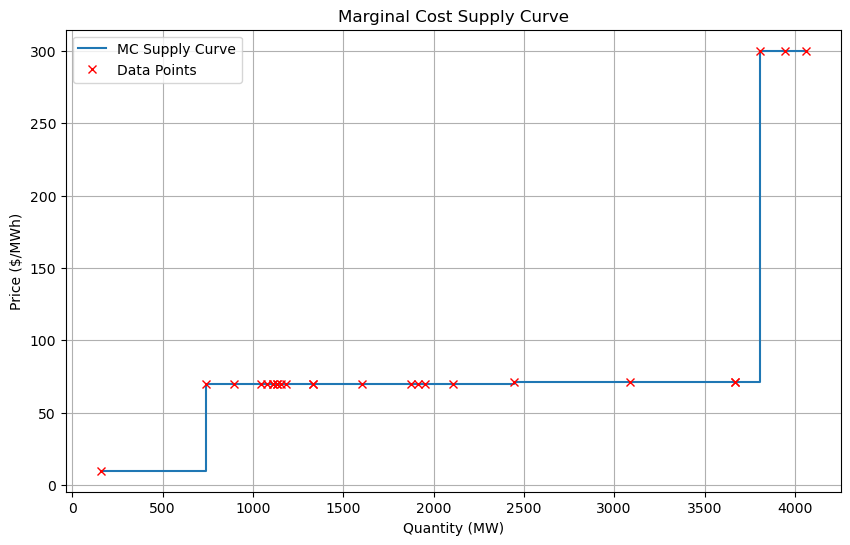

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume single_day_six_pm_filtered_df is already loaded and sorted by MC (or price) ascending

# 1. Rename the column "MC per MW/h" to "price dollar/MWh"
single_day_six_pm_filtered_df.rename(
    columns={"MC per MW/h": "price dollar/MWh"},
    inplace=True
)

# 2. Compute the cumulative capacity using the 'MAXAVAIL_x' column
single_day_six_pm_filtered_df['CumulativeCapacity'] = single_day_six_pm_filtered_df['AVAILABILITY'].cumsum()

# 3. Plot the stepwise MC (price) function
plt.figure(figsize=(10, 6))

# Plot the step function (supply curve)
plt.step(
    single_day_six_pm_filtered_df['CumulativeCapacity'],
    single_day_six_pm_filtered_df['price dollar/MWh'],
    where='post',
    label="MC Supply Curve"
)

# 4. Overlay cross markers for each data point
plt.plot(
    single_day_six_pm_filtered_df['CumulativeCapacity'],
    single_day_six_pm_filtered_df['price dollar/MWh'],
    linestyle="None",   # no line, only markers
    marker="x",         # cross markers
    color="red",
    label="Data Points"
)

# 5. Label the axes
plt.xlabel("Quantity (MW)")
plt.ylabel("Price ($/MWh)")
plt.title("Marginal Cost Supply Curve")

# Add a legend and grid for clarity
plt.legend()
plt.grid(True)

plt.show()

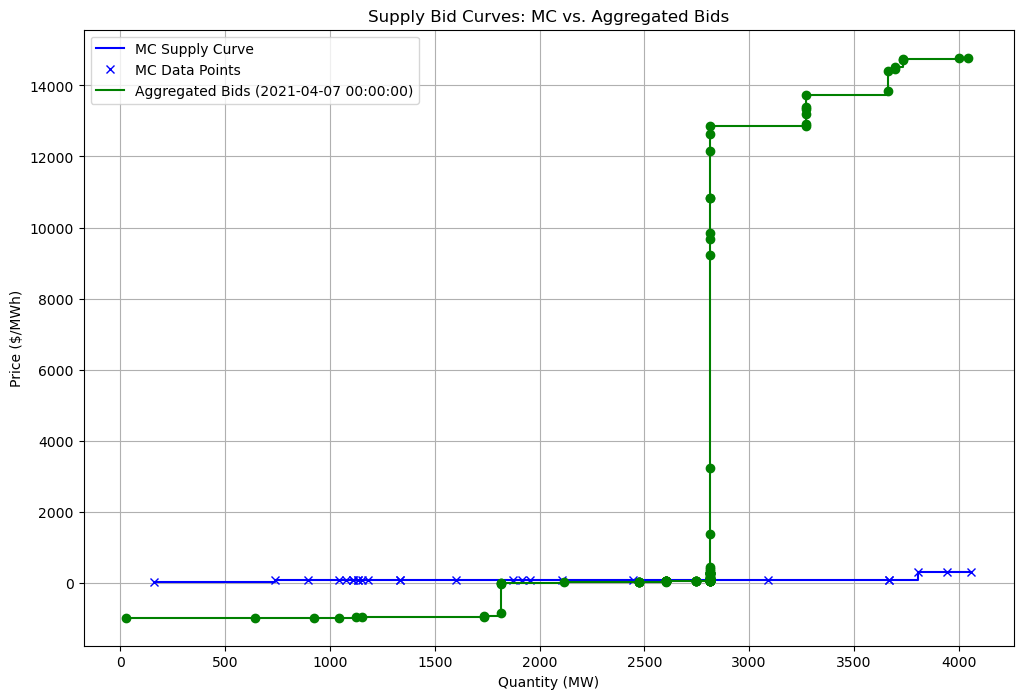

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Plot 1: MC Supply Curve from single_day_six_pm_filtered_df
# -------------------------------

# Rename the column "MC per MW/h" to "price dollar/MWh"
single_day_six_pm_filtered_df.rename(
    columns={"MC per MW/h": "price dollar/MWh"},
    inplace=True
)

# Compute the cumulative capacity using the 'AVAILABILITY' column
single_day_six_pm_filtered_df['CumulativeCapacity'] = single_day_six_pm_filtered_df['AVAILABILITY'].cumsum()

# -------------------------------
# Create a single figure for both curves
plt.figure(figsize=(12, 8))

# Plot the stepwise MC supply curve
plt.step(
    single_day_six_pm_filtered_df['CumulativeCapacity'],
    single_day_six_pm_filtered_df['price dollar/MWh'],
    where='post',
    label="MC Supply Curve",
    color="blue"
)

# Overlay cross markers for each MC data point
plt.plot(
    single_day_six_pm_filtered_df['CumulativeCapacity'],
    single_day_six_pm_filtered_df['price dollar/MWh'],
    linestyle="None",  # markers only
    marker="x",
    color="blue",
    label="MC Data Points"
)

# -------------------------------
# Plot 2: Aggregated Bids Supply Curve from aggregated_bids_df
# -------------------------------

# If there are multiple settlement dates, plot each with its own label.
# If it's a single date, this loop will simply plot that one curve.
for settlement_date, df in aggregated_bids_df.groupby("SETTLEMENTDATE"):
    plt.step(
        df["CUMULATIVE_VOLUME"],
        df["PRICE"],
        where="post",
        label=f"Aggregated Bids ({settlement_date})",
        color="green"
    )
    # Optionally add markers for aggregated bid points:
    plt.plot(
        df["CUMULATIVE_VOLUME"],
        df["PRICE"],
        linestyle="None",
        marker="o",
        color="green"
    )

# -------------------------------
# Final touches: labels, title, legend, grid
plt.xlabel("Quantity (MW)")
plt.ylabel("Price ($/MWh)")
plt.title("Supply Bid Curves: MC vs. Aggregated Bids")
plt.legend()
plt.grid(True)

# Display the combined plot
plt.show()

# What do I notice
- OLD: The aggregated max bid quantity extends far past the max avail? How is this possible? I'm not sure this is right
- But now, it's capped correctly

# Find the residual demand

In [103]:
merged_df

,SETTLEMENTDATE,DUID,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,INTERVENTION,DISPATCHMODE,AGCSTATUS,INITIALMW,TOTALCLEARED,RAMPDOWNRATE,RAMPUPRATE,LOWER5MIN,LOWER60SEC,LOWER6SEC,RAISE5MIN,RAISE60SEC,RAISE6SEC,LOWERREG,RAISEREG,AVAILABILITY,RAISEREGENABLEMENTMAX,RAISEREGENABLEMENTMIN,LOWERREGENABLEMENTMAX,LOWERREGENABLEMENTMIN,SEMIDISPATCHCAP
0,NaT,-,CS Energy Limited,Callide Power Station,QLD1,Generating Unit,Market,Non-Scheduled,Fossil,Black Coal,Combustion,Steam Sub-Critical,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,ADPBA1,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Bidirectional Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,ADPBA1G,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,ADPBA1L,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Load,Market,Scheduled,Battery storage,Grid,Storage,Battery and Inverter,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,ADPMH1,South Australian Water Corporation,Adelaide Desalination Plant,SA1,Generating Unit,Market,Non-Scheduled,Hydro,Water,Renewable,Run of River,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067369,2021-04-09 23:40:00,YWPS4,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,374.63165,375.0,180.00,180.00,15.0,20.0,13.67737,0.0,0.0,0.0,0.0,0.0,375.0,385.0,250.0,385.0,250.0,0.0
4067370,2021-04-09 23:45:00,YWPS4,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,374.06708,375.0,180.00,180.00,15.0,20.0,15.00000,0.0,0.0,0.0,0.0,0.0,375.0,385.0,250.0,385.0,250.0,0.0
4067371,2021-04-09 23:50:00,YWPS4,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,377.17215,375.0,180.00,180.00,15.0,20.0,15.00000,0.0,0.0,0.0,0.0,0.0,375.0,385.0,250.0,385.0,250.0,0.0
4067372,2021-04-09 23:55:00,YWPS4,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y,0.0,0.0,1.0,374.34937,375.0,180.00,180.00,15.0,20.0,15.00000,0.0,0.0,0.0,0.0,0.0,375.0,385.0,250.0,385.0,250.0,0.0


In [38]:
all_dispatches_for_single_day_auction = merged_df[merged_df['SETTLEMENTDATE']  == '2021-04-09 18:05:00'] 

In [39]:
total_value = all_dispatches_for_single_day_auction['TOTALCLEARED'].sum()
total_value

24683.341

This is the total demand, which is exactly what was dispatched. We need to subtract what will be provided by each rival firm at each price level to find the residual demand.

In [41]:
# Find all bids for the 6:00-6:05pm interval
# INTERVAL_DATETIME in the bids data indicates the start of the 5-minute interval that the bids apply to
# We need to take the total demand and minus all the other rival bids. 
# If this is happening at a firm level, then that needs to be automated before moving on 
# so we need to find all the firm's supply bids or just do 

all_bids_for_single_day_auction = bids_with_duid[bids_with_duid['INTERVAL_DATETIME']  == '2021-04-09 18:00:00'] 
all_bids_for_single_day_auction

,SETTLEMENTDATE,DUID,BIDTYPE,OFFERDATE,MAXAVAIL,ENABLEMENTMIN,ENABLEMENTMAX,LOWBREAKPOINT,HIGHBREAKPOINT,BANDAVAIL1,BANDAVAIL2,BANDAVAIL3,BANDAVAIL4,BANDAVAIL5,BANDAVAIL6,BANDAVAIL7,BANDAVAIL8,BANDAVAIL9,BANDAVAIL10,INTERVAL_DATETIME,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation
2527,2021-04-09,AGLHAL,ENERGY,2021-04-09 17:20:58,156.0,NaN,NaN,NaN,NaN,32.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,163.0,2021-04-09 18:00:00,EnergyAustralia Yallourn Pty Ltd,Hallett Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Natural Gas / Diesel,Combustion,Open Cycle Gas turbines (OCGT),Y
5119,2021-04-09,AGLSOM,ENERGY,2021-04-09 15:16:13,160.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.0,2021-04-09 18:00:00,AGL Hydro Partnership,Somerton Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y
7711,2021-04-09,ANGAST1,ENERGY,2021-04-08 13:05:22,49.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,50.0,2021-04-09 18:00:00,Snowy Hydro Limited,Angaston Power Station,SA1,Generating Unit,Market,Scheduled,Fossil,Diesel,Combustion,Compression Reciprocating Engine,Y
15341,2021-04-09,APD01,RAISE5MIN,2021-04-09 17:47:59,450.0,0.0,0.0,0.0,0.0,50.0,50.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,304.0,2021-04-09 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15342,2021-04-09,APD01,RAISE60SEC,2021-04-09 17:47:46,450.0,0.0,0.0,0.0,0.0,30.0,30.0,30.0,30.0,26.0,0.0,0.0,0.0,0.0,304.0,2021-04-09 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016529,2021-04-09,YWPS4,LOWERREG,2021-03-23 13:09:26,20.0,250.0,385.0,270.0,385.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,2021-04-09 18:00:00,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y
3016530,2021-04-09,YWPS4,RAISE5MIN,2021-03-23 13:09:26,0.0,250.0,390.0,250.0,380.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,10.0,2021-04-09 18:00:00,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y
3016531,2021-04-09,YWPS4,RAISE60SEC,2021-03-23 13:09:26,10.0,220.0,400.0,220.0,390.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,10.0,2021-04-09 18:00:00,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y
3016532,2021-04-09,YWPS4,RAISE6SEC,2021-03-23 13:09:26,15.0,220.0,405.0,220.0,390.0,0.0,0.0,0.0,10.0,5.0,0.0,0.0,0.0,0.0,10.0,2021-04-09 18:00:00,EnergyAustralia Yallourn Pty Ltd,Yallourn 'W' Power Station,VIC1,Generating Unit,Market,Scheduled,Fossil,Brown Coal,Combustion,Steam Sub-Critical,Y
